In [34]:
!pip install scikit-plot
!pip install kaggle
!pip install kagglehub --upgrade


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/68.0 kB ? eta -:--:--
   ------------------------------------ --- 61.4/68.0 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 68.0/68.0 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.2.1
    Uninstalling kagglehub-0.2.1:
      Successfully uninstalled kagglehub-0.2.1


# REGRESSION MODEL

#### Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import scikitplot as skplt
from scipy.stats import skew
import kagglehub

#### Import Data - Public Funding and Donations to UK Political Parties (Regression)

https://www.kaggle.com/datasets/thedevastator/donations-accepted-by-political-parties-in-the-u



In [24]:
# Path to your CSV file
csv_path = r"C:\Users\MSI\OneDrive\1. BiG_dAtA_Master_Degree\thesis\Code\Data\Regression\Donations accepted by political parties.csv"

# Load the CSV
data = pd.read_csv(csv_path)

# Display basic information
print("Dataset Info:")
print(data.info())
print("\nColumn Names:")
print(data.columns)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65278 entries, 0 to 65277
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          65278 non-null  int64  
 1   ECRef                          65278 non-null  object 
 2   RegulatedEntityName            65278 non-null  object 
 3   RegulatedEntityType            65278 non-null  object 
 4   Value                          65278 non-null  object 
 5   AcceptedDate                   64265 non-null  object 
 6   AccountingUnitName             56957 non-null  object 
 7   DonorName                      65193 non-null  object 
 8   AccountingUnitsAsCentralParty  65278 non-null  bool   
 9   IsSponsorship                  65278 non-null  bool   
 10  DonorStatus                    65220 non-null  object 
 11  RegulatedDoneeType             7090 non-null   object 
 12  CompanyRegistrationNumber      1

C:\Users\MSI\AppData\Local\Temp\ipykernel_15256\916651770.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path)


In [25]:
print("\nColumn Names:")
print(data.columns)


Column Names:
Index(['index', 'ECRef', 'RegulatedEntityName', 'RegulatedEntityType', 'Value',
       'AcceptedDate', 'AccountingUnitName', 'DonorName',
       'AccountingUnitsAsCentralParty', 'IsSponsorship', 'DonorStatus',
       'RegulatedDoneeType', 'CompanyRegistrationNumber', 'Postcode',
       'DonationType', 'NatureOfDonation', 'PurposeOfVisit', 'DonationAction',
       'ReceivedDate', 'ReportedDate', 'IsReportedPrePoll',
       'ReportingPeriodName', 'IsBequest', 'IsAggregation',
       'RegulatedEntityId', 'AccountingUnitId', 'DonorId', 'CampaigningName',
       'RegisterName', 'IsIrishSource'],
      dtype='object')


In [26]:
data.head()

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
0,0,NC0408174,Mr Andy Street,Regulated Donee,"£1,876.56",02/09/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
1,1,NC0408173,Mr Andy Street,Regulated Donee,"£2,700.00",02/09/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
2,2,NC0408177,Mr Andy Street,Regulated Donee,"£4,852.58",30/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
3,3,NC0408176,Mr Andy Street,Regulated Donee,"£2,500.00",30/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
4,4,NC0408170,Mr Andy Street,Regulated Donee,"£4,524.05",29/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False


### EXPLORATION AND CLEANING DATA

###### Summary of Excluded Columns
- ###### Identifiers: index, ECRef, RegulatedEntityId, AccountingUnitId, DonorId – No predictive value, only unique identifiers.
- ###### High Missing Rate: RegulatedDoneeType (~89%), CompanyRegistrationNumber (~82%), NatureOfDonation (~85%), PurposeOfVisit (~96%), DonationAction (~99.6%), CampaigningName (~99.99%) – Too many missing values, unusable.
- ###### Redundant: AccountingUnitName (~13%, redundant with RegulatedEntityName), ReceivedDate (~4%, similar to AcceptedDate), ReportingPeriodName (redundant with AcceptedDate), Reported ReportedDate (administrative) – Duplicated or irrelevant information.
- ###### High Cardinality: DonorName (unique names), RegulatedEntityName (1,384 values), Postcode (4,559 values) – Generate excessive dummy columns, increasing complexity and risk of overfitting.
- ###### Low Variability: IsReportedPrePoll (only False), RegisterName (~90% Great Britain) – Do not provide predictive information.

In [27]:
# Select definitive columns
selected_columns = [
    'Value', 'RegulatedEntityType', 'DonorStatus', 'DonationType', 
    'AcceptedDate', 'IsSponsorship', 'IsBequest', 'IsAggregation', 
    'AccountingUnitsAsCentralParty', 'IsIrishSource'
    ]
data_selected = data[selected_columns].copy()  # Create independent copy
print(data_selected)

             Value    RegulatedEntityType                 DonorStatus  \
0        £1,876.56        Regulated Donee  Registered Political Party   
1        £2,700.00        Regulated Donee  Registered Political Party   
2        £4,852.58        Regulated Donee  Registered Political Party   
3        £2,500.00        Regulated Donee  Registered Political Party   
4        £4,524.05        Regulated Donee  Registered Political Party   
...            ...                    ...                         ...   
65273   £10,000.00  Permitted Participant                     Company   
65274  £100,000.00  Permitted Participant                  Individual   
65275   £40,000.00  Permitted Participant                  Individual   
65276   £50,000.00        Political Party                  Individual   
65277   £15,000.00        Political Party                  Individual   

      DonationType AcceptedDate  IsSponsorship  IsBequest  IsAggregation  \
0         Non Cash   02/09/2019          False 

In [28]:
#Clean and convert 'Value'
data_selected.loc[:, 'Value'] = data_selected['Value'].replace('[\£,]', '', regex=True)
data_selected.loc[:, 'Value'] = pd.to_numeric(data_selected['Value'], errors='coerce')
data_selected['Value'] = data_selected['Value'].astype(float)
print(data_selected)

print("NEW Dataset Info:")
print(data_selected.info())

           Value    RegulatedEntityType                 DonorStatus  \
0        1876.56        Regulated Donee  Registered Political Party   
1        2700.00        Regulated Donee  Registered Political Party   
2        4852.58        Regulated Donee  Registered Political Party   
3        2500.00        Regulated Donee  Registered Political Party   
4        4524.05        Regulated Donee  Registered Political Party   
...          ...                    ...                         ...   
65273   10000.00  Permitted Participant                     Company   
65274  100000.00  Permitted Participant                  Individual   
65275   40000.00  Permitted Participant                  Individual   
65276   50000.00        Political Party                  Individual   
65277   15000.00        Political Party                  Individual   

      DonationType AcceptedDate  IsSponsorship  IsBequest  IsAggregation  \
0         Non Cash   02/09/2019          False      False          Fals

In [29]:
#Handle missing values with MODA
cat_columns = ['RegulatedEntityType', 'DonorStatus', 'DonationType', 'IsIrishSource']
imputer_cat = SimpleImputer(strategy='most_frequent') # Imputed by MODA

data_selected.loc[:, cat_columns] = imputer_cat.fit_transform(
    data_selected[cat_columns])

# Drop rows with missing AcceptedDate
data_selected = data_selected.dropna(subset=['AcceptedDate'])

# Verification
print("Missing values after imputation:")
print(data_selected.isna().sum())

Missing values after imputation:
Value                            0
RegulatedEntityType              0
DonorStatus                      0
DonationType                     0
AcceptedDate                     0
IsSponsorship                    0
IsBequest                        0
IsAggregation                    0
AccountingUnitsAsCentralParty    0
IsIrishSource                    0
dtype: int64


In [30]:
#Feature EngineerAcceptedDate
# Adapted function to convert text or datetime to datetime
def convert_to_datetime(value):
    if pd.isna(value):
        return pd.NaT
    if isinstance(value, pd.Timestamp) or isinstance(value, datetime):  # Preserve Timestamps or datetime
        return pd.to_datetime(value)
    if isinstance(value, str):  # Handle text dates
        try:
            # Try dd/mm/yyyy or d/m/yyyy (both handled by %d/%m/%Y)
            return pd.to_datetime(value, format='%d/%m/%Y', errors='coerce')
        except:
            return pd.NaT
    return pd.NaT

# Apply conversion
# Observation: Convert text dates to datetime, preserve Timestamps. Keep NaT for nulls/invalid dates.
data_selected.loc[:, 'AcceptedDate'] = data_selected['AcceptedDate'].apply(convert_to_datetime)
#Verify
print("NaT dates (invalid or null):", data_selected['AcceptedDate'].isna().sum())

NaT dates (invalid or null): 0


In [31]:
# Extract Year
# Convert AcceptedDate to datetime64[ns]
data_selected['AcceptedDate'] = pd.to_datetime(data_selected['AcceptedDate'], errors='coerce', dayfirst=True)
# Extract year and drop the original column
data_selected['Year'] = data_selected['AcceptedDate'].dt.year
data_selected.drop(columns='AcceptedDate', inplace=True)

# Verification
print("\nUnique values of Year (without NaN)):", sorted(data_selected['Year'].dropna().unique()))


Unique values of Year (without NaN)): [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


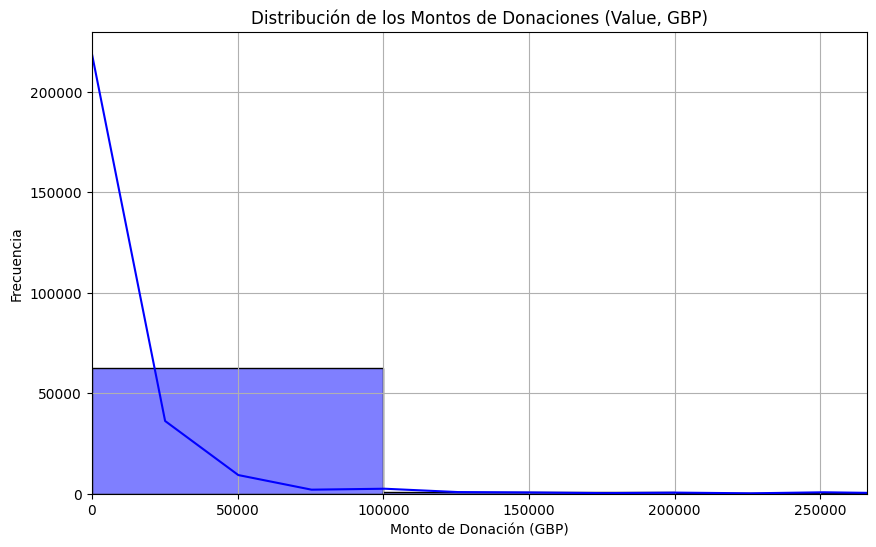

In [33]:
# Plot distribution before transformation
# Observation: Generate histogram with KDE to visualize long-tail distribution. Exclude NaN.
plt.figure(figsize=(10, 6))
sns.histplot(data_selected['Value'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribución de los Montos de Donaciones (Value, GBP)')
plt.xlabel('Monto de Donación (GBP)')
plt.ylabel('Frecuencia')
plt.xlim(0, data_selected['Value'].quantile(0.99))  # Limit to 99th percentile to avoid extreme outliers
plt.grid(True)
plt.show()

In [35]:
# Transform 'Value' with log1p
# Observation: Apply log1p to reduce skewness. Handle NaN and ensure no negative values.
if (data_selected['Value'] < 0).any():
    print("Advertencia: Valores negativos en Value. Se convertirán a NaN para log1p.")
    data_selected.loc[data_selected['Value'] < 0, 'Value'] = np.nan
data_selected.loc[:, 'Value'] = np.log1p(data_selected['Value'])

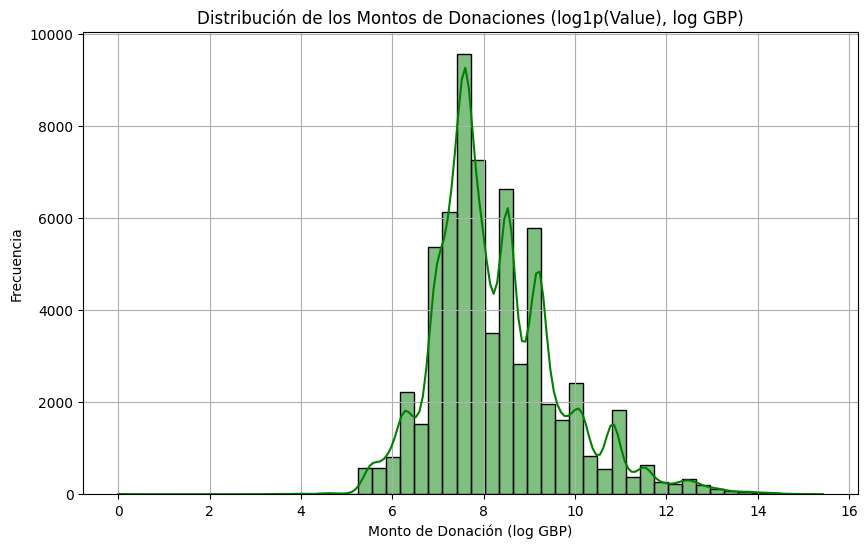

In [37]:
# Plot distribution after transformation
# Observation: Generate histogram with KDE to visualize more symmetric distribution. Exclude NaN.
plt.figure(figsize=(10, 6))
sns.histplot(data_selected['Value'].dropna(), bins=50, kde=True, color='green')
plt.title('Distribución de los Montos de Donaciones (log1p(Value), log GBP)')
plt.xlabel('Monto de Donación (log GBP)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

IMPORT DATA - Non-Profit Funding in the EU (Classification)

https://www.kaggle.com/datasets/sarmitamajumdar/finding-donors-for-a-charity/data